In [1]:
import tensorflow as tf

import numpy as np
import torch.nn.functional as F
from kymatio import Scattering2D
import kymatio.datasets as scattering_datasets
import kymatio
import torch
import argparse
import math

from os import path 

from keras.layers import Input
from keras.models import Model

import matplotlib.pylab as plt
import numpy as np

import blusky.datasets as datasets
from blusky.transforms.transform_factories_2d import vanilla_scattering_transform

from blusky.transforms.apply_father_wavelet_2d import ApplyFatherWavlet2D
from blusky.transforms.cascade_2d import Cascade2D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.default_decimation import DefaultDecimation
from blusky.utils.pad_2d import Pad2D, pad_to_log2
from blusky.wavelets.wavelet_factories_2d import vanilla_gabor_2d, vanilla_morlet_2d

Using TensorFlow backend.


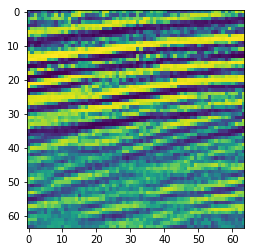

In [2]:
from os.path import dirname, join
from PIL import Image

N = 64
J = 4

test_data = join(dirname(datasets.__file__), "test_tiles", "horizon0.png")
test_data = np.array(Image.open(test_data))[:N, :N]

plt.figure()
plt.imshow(test_data)
plt.show()

# if you want arbitrary size data
#np.random.seed(42)
#N = 32
#data = np.random.rand(1,N,N,1).astype(np.float32)

In [3]:
data = np.expand_dims(np.expand_dims(test_data, axis=0), axis=-1)
data = np.ascontiguousarray(data.astype(np.float32))

### Construct the Kymatio transform

In [4]:
scattering = Scattering2D(J=J, shape=(N,N), max_order=2)
_data = torch.from_numpy(data[0,:,:,0])
result = scattering(_data).numpy()

In [5]:
# standardize the ordering of the coefficients.
psi = scattering.Psi

counter = 0
coeffs = []
for n1 in range(len(psi)):
    j1 = psi[n1]['j']
    for n2 in range(len(psi)):
        j2 = psi[n2]['j']
        if(j1 < j2):
            coeffs.append((counter, j1, psi[n1]['theta'], psi[n2]['j'], 
                           psi[n2]['theta']))
            counter += 1
            
            
# groupby j1
from itertools import groupby, chain

master_index = []

_coeffs = sorted(coeffs, key = lambda x : x[1])
for key, val in groupby(_coeffs, key=lambda x : x[1]):
    # sort by j2
    _coeffs2 = sorted(val, key = lambda x : x[3])
    for key2, val2 in groupby(_coeffs2, key=lambda x : x[3]):
        # sort by theta1
        _coeffs2 = sorted(val2, key = lambda x : x[2])
        for key3, val3 in groupby(_coeffs2, key=lambda x : x[2]):
            #sort by theta2
            _coeffs3 = sorted(val3, key = lambda x : x[4])
            #print (key, key2, key3, _coeffs3)
            master_index.append(_coeffs3)
            
master_index = list(chain(*master_index))

indx = [i[0] for i in master_index]

In [16]:
### Construct the Scattering Network

In [6]:
model, viz = vanilla_scattering_transform(J, (N,N,1), 0.004,
                          num_angles=8)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
depthwise_conv2d_1 (DepthwiseCo (None, 128, 128, 8)  400         reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_2 (DepthwiseCo (None, 128, 128, 8)  400         reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
depthwise_

In [7]:
def pad2shape(wav, N):
    x =(N-wav.shape[0])//2
    return np.pad(wav, ((x+1,x), (x+1,x)), mode='constant', constant_values=0)

Calling predict here just outputs the transform, there's no optimizer or other layers compiled in.

Note, the network isn't compiled we don't have an optimizer attached to it. The first call to predict will include compilation, subsequent calls wont.

In [8]:
blusky = model.predict(data)
res = np.hstack([i[0,0,0,:] for i in blusky])

In [10]:
# standardizes the ordering of the coefficients 
ordered = result[:,:,:].copy()
for i in range(33, ordered.shape[0]):
    ordered[i] = result[indx[i-33]+33,:,:]

### First order transform

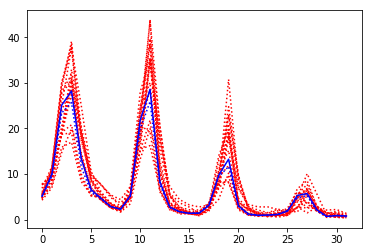

In [17]:
plt.figure()
for i in range(4):
    for j in range(4):
        plt.plot(ordered[1:33,i,j], ':r')
plt.plot(res[:32], '-b')
plt.plot(0.5*(ordered[1:33,2,2] + ordered[1:33,3,3]), ':b')
plt.show()

### Second order transform

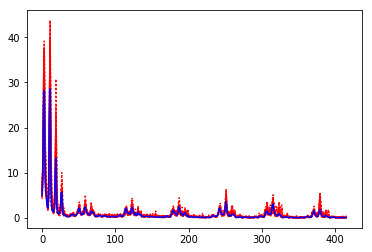

In [13]:
plt.figure()
for i in range(4):
    for j in range(4):
        plt.plot(ordered[1:,i,j], ':r')
plt.plot(res[:], '-b')
plt.show()

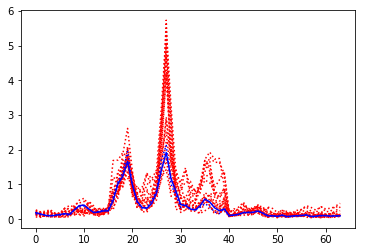

In [15]:
plt.figure()
for i in range(4):
    for j in range(4):
        plt.plot(ordered[-64:,i,j], ':r')
plt.plot(res[-64:], '-b')
# in the middle of the padded image
plt.plot(0.5*(ordered[-64:,2,2] + ordered[-64:,3,3]), ':b')
plt.show()